In [1]:
'''Karan and Syarief '''
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
import scipy.integrate as integrate
from scipy.integrate import quad
from scipy.special import kv
import csv

In [27]:
                                                                                                                                                #constants from assignment 3 solutions changed for this assignment

M = 9.2         # Mass of J1820* in M_sun Chakroboty paper
M_sun = 1.988e33     # Solar mass in g
Ledd = 1.26e38 * M   # Eddington luminosity in erg/s
lightspeed = 2.997e10         # Speed of light in vaccum in cm/s
G = 6.67e-8          # Gravitational constant in erg cm/g^2
rg = G*M*M_sun/lightspeed**2# Gravitational radius in cm
me = 9.1e-28         # Electron mass in g
q = 4.8e-10          # Electron charge in esu
#eta = 1e-7
eta = 0.15          # radiative efficiency
R0 = 10*rg 
print(np.log10(R0))# beginning radius of the blob in cm
p = 4                # power law index
nuSSA = 1e12            # frequency in Hz self synchrotron
omega = 2*np.pi*nuSSA # angular frequency
pitch = 63*np.pi/180     # pitch angle in radians 63 from  radio parallax paper
vr = 0.89*lightspeed #broadband rodi paper cm/s
planck = 1e-27 # planck constant in erg*s
thomp_cross= 7e-25 #cm**2
print(np.log10(vr))
lorentz_min = 1.1
lorentz_cyc_max = 2.0
lorentz = 1000 #find literature for this value
theta = 150*(10**3)/(0.5*10**6) #KT/mc*2, KT from chakroboty paper
Distance_to_maxi = 2.96 * (3*10**21) # kpc distance to MAXIJ in cm from Atri paper
B_paper = 1.4e6 #gauss from Rodi paper

7.132956555432109
10.426076749590557


In [3]:
#import data from Rodi paper for flux densnity
filename = 'Flux_density_data.csv'
# Open the CSV file and read the flux and frequency
with open(filename, 'r') as file:
    # read the file
    csv_reader = csv.reader(file)

    # Skip the header if it exists
    next(csv_reader, None)

    # Transpose the rows to columns using zip
    columns = list(zip(*csv_reader))

    column_arrays = [np.array(column_data) for column_data in columns]

data_freq = [float(items) for items in column_arrays[0]]#column_arrays[0] #hz
data_flux = [float(items) for items in column_arrays[1]] #convert flux to mjy

In [4]:
def absorption(freq,C,mag,p):
    '''Evaluate the absorption coefficent for various p indicies
    include angular dependence
    Follows rybecki and Lightmann ch.6
    input:
    freq- frequnecy float hz
    C: see function C_consant
    mag: magnetic field strength gauss
    variables:
    gammas- evaluate a specific gamma function for different p values
    absorb- the absorption coeifficent
    p- p index

    return
    absorbtion coefficient'''
    gamA = gamma((3*p+2)/12)
    gamB = gamma((3*p+22)/12)
    fracA = np.sqrt(3)*q**3/(8*np.pi*me)
    fracB = (3*q/(2*np.pi*me**3 * lightspeed**5))
    fracB  = np.power(fracB, p/2)

    abs_const = gamA*gamB*fracA*fracB

    absorb = abs_const*C*(mag**((p+2)/2))*(freq**(-(p+4)/2))

    return absorb

In [5]:
def cyclo_freq(gamma, mag):
  '''Define the cyclotron freqeuncy regime in terms of larmor frequency and
   lorentz factor
   input:
   gamma - loretz factor uniteless
   mag- float magnetic field strength in gauss

   return
   cyclotorn frequency float
   '''
   #wg =eB/mc = 1.8e7 Bg/s
  wg = (1.8e7)*mag #angular frequency
  wg = wg/(2*np.pi) # convert to frequncy Hz

  return gamma*wg

In [6]:
radiusSGRA = R0 #radius of corona, not SGRA


Rkpc = R0/(10**21)
B0 = ((nuSSA/100e6)/Rkpc**(1/3))
B0 = ((B0)**(3/4))/1e3 # intial


# def magentic_field(Radius, dz):
#     '''I know it's spelled wrong, but it's too late
#     Calculate the Magnetic field strength of the jet from equipartition
#     Define a conserved flux , and return a 1/r dependent field
#     input:
#     radius- radius of jet in cm

#     variables:
#     B_r - magnetic field Gauss
#     return
#     B_r'''

#     B_r  = mag_flux/(Radius) #gauss
#     return B_r

In [7]:
#redefine frequency array between min and max of characteristic frequncy

v_min = B_paper*(lorentz_min**2)*(4.3e6) #hz
v_max  = B_paper*(lorentz**2)*(4.3e6) #hz
#v_max is too small to see cutoff
freq_arr = np.logspace(np.log10(v_min), np.log10(v_max), num=1000)
A0 =4*np.pi*radiusSGRA**2 # area of sphere of 10rg
#eta =0.1
# mdot = (1e-8)*M_sun/(1e7)
def C_constant(L_edd, energy,p):
    '''Calculate the C constant using the eddington luminosity
    and electron energy, for various p indicies

    input:
    L_eff -float of  eddington luminosity  erg/s
    energy- energy of electron in ergs
    p - power law index unitless p cannot be 2
    variables:
    Ub- magnetic field density
    lorentz - gamma factor
    C_hat: C constant for absorption coefficent
    C : other C constant for power
    return
    C, C_hat'''
    Ut = (eta*L_edd)/(4*np.pi*R0*R0*vr)
    Ue = Ut
    Ub = Ue #equipartion
    #numerically integrate the energy array
    B = np.sqrt(4*np.pi*Ub) # for verification
    print(Ue)
    print("this is B", np.log(B))
    Energy_integral = np.trapz(energy**(-p+1))

    C_hat = Ut/Energy_integral

    C = C_hat/(me*lightspeed**2)  # power
    return C, C_hat


In [8]:
def emission_coef(freq, C_const, mag,p):
    '''Evaluate the sychlotron emission coefficent for various powers of p
    from rybecki and lightmann ch.6
    total power per unit volume per unit frequency
    input:
    freq- frequnecy
    C: see function C_consant
    mag: magnetic field strength see function mag_density
    variables:
    gammas- evaluate a specific gamma function for different p values
    emission- the emission coeifficent
    p - p index unitless

    return
    emission'''
    gamC = gamma((p/4)+(19/12))
    gamD = gamma((p/4)-(1/12))
    fracA  = (np.sqrt(3*q**3))/((p+1)*2*np.pi*me*lightspeed**2)

    ems_const = gamC*gamD*fracA

    #for clarity
    the_frac_with_p = (me*lightspeed*2*np.pi*freq)/(3*q*mag)
    power_of_p = np.power(the_frac_with_p, -(p-1)/2)


    emission = ems_const * mag * C_const * power_of_p
    return emission

In [9]:
def momentum(lorentz):
  '''Define a unitless momentum to calculate the emission spectrum
  from K. Katarzynski ´ 1,2, G. Ghisellini1, R. Svensson, and J. Gracia3 2006
  input:
  lorentz - loretnz factor
  return dimensionless momentum
  '''
  # paragraph below equation 1 in paper mentioned
  p_no_dim = np.sqrt((lorentz**2) - 1)
  return p_no_dim

In [10]:
def emissivity_cyc(freq, mag, mom):
  '''Define the emissivity by cyclotron emission of the corona for lorentz <2
  input:
  mu -frequency array hz
  mag - array magnetic field strength gauss
  mom - electron momentum unitless
  '''
  #calculate the emission by breaking it down into fractions
  mu_l = q*mag/(2*np.pi*me*lightspeed) # larmor frequency
  fracA = (4*mom**2)/3
  Ub = mag**2/(8*np.pi)
  fracB = (thomp_cross*lightspeed)/mu_l
  fracC = 2/(1+ 3*mom**2)
  fracD = np.exp(2*(1-(freq/mu_l))/(1+3*mag**2))
  return fracA*fracB*fracC*fracD

In [11]:
def number_distro(lorentz):
  '''Return a number distribution as a function of gamma
  from BHjet paper
  '''
  n = 1 # i assume this value
   # from BHjet paper
  N_o = (n/me*lightspeed**3)/(theta * kv(2,1/theta))
  fracA = (N_o*lorentz/(np.sqrt(lorentz**2 -1)))
  fracB = ((lorentz**2 - 1) * np.exp(-lorentz/theta))
  N = fracA * fracB
  return N


In [12]:
def integrated_emmisivity(N, j):
  '''Integrate the emissivity wrt to gamma follow Bhjet paper
   Define the emissivity by cyclotron emission of the corona for lorentz <2
  input:
  gamma__min, gamma_max - float, min and max of gamma array this is different if
  in synch or cyclo regime
  N - func of distribution of electrons in the corona with N(gamma)
  j - func emissivity either cyclo or synchro'''
  the_integral = np.trapz(N*j)
  return the_integral


In [13]:
#calculate the C constant
temp_electron_energy = np.linspace(lorentz_min*me*lightspeed**2, lorentz*me*lightspeed**2)
C, C_hat = C_constant(Ledd,temp_electron_energy, p=4)
def source(absorb, emission):
    '''Calculate the source function in Cgs units
    Sv = power/(4*pi*absorption_coefficent)
    input:
    absorb - absorption_coefficent
    emiision - total power
    '''
    return emission/(4*np.pi*absorb)

2812223979142.548
this is B 15.598010492431472


In [14]:
def Iv(source, tau):
    '''Calculate the intensity in cgs units'''
    Iv = source*(1-np.exp(-tau))
    return Iv
#IvSSA = Iv(Sv,tau)
def flux_spec(freq, Iv,radius):
    '''Calculate the flux spectrum normalize around vssa and inital luminosity'''
    #normalize flux around inital luminosity
    Fv = Iv*(radius/Distance_to_maxi)**2
    jansky_cov = 10**-26 # convert to mjansky
    Fv = Fv/jansky_cov
    return Fv
#Fv = flux_spec(freq_arr, IvSSA,radiusSGRA)
def optical_depth(absorb, radius):
  ''' Calculate the optical depth of the corona
  input:
  Absorb: float of absorption coeifficent cgs units
  radius: float of radius of blob in cm'''
  return absorb*radius


In [15]:
C, C_hat = C_constant(Ledd,temp_electron_energy, p=4)

2812223979142.548
this is B 15.598010492431472


2812223979142.548
this is B 15.598010492431472
2812223979142.548
this is B 15.598010492431472


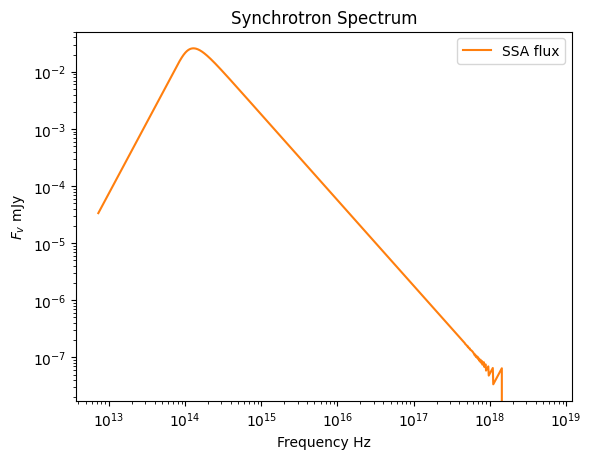

In [16]:
total_flux = []
total_int = []
temp_electron_energy =  np.linspace(me*lightspeed**2, lorentz*me*lightspeed**2,num=100)
C, C_hat = C_constant(Ledd,temp_electron_energy, p=4)
for i in [0]: # only take first slice of jet as spectrum
    mag_temp =B_paper
    C_temp, C_hat_temp = C_constant(Ledd,temp_electron_energy, p=4)
    emission_temp = emission_coef(freq_arr,C_temp, mag_temp,p=4)
    absorb_temp = absorption(freq_arr,C_hat_temp, mag_temp,p=4)
    source_temp = source(absorb_temp,emission_temp)
    tau_temp = optical_depth(absorb_temp, radiusSGRA)

    Iv_temp = Iv(source_temp,tau_temp)
    total_int.append(Iv_temp)
    Fv_temp = flux_spec(freq_arr, Iv_temp, radiusSGRA)
    total_flux.append(Fv_temp)
    #plt.plot(freq_arr,Fv_temp)

#sum all the slices
total_spectrum = [sum(x) for x in zip(*total_flux)]

plt.title("Synchrotron Spectrum")
plt.xscale('log')
plt.yscale("log")
plt.ylabel("$F_v$ mJy")
plt.xlabel("Frequency Hz")
plt.plot(freq_arr, total_spectrum, color='tab:orange',label= "SSA flux")
plt.legend()
plt.show()


2812223979142.548
this is B 15.598010492431472


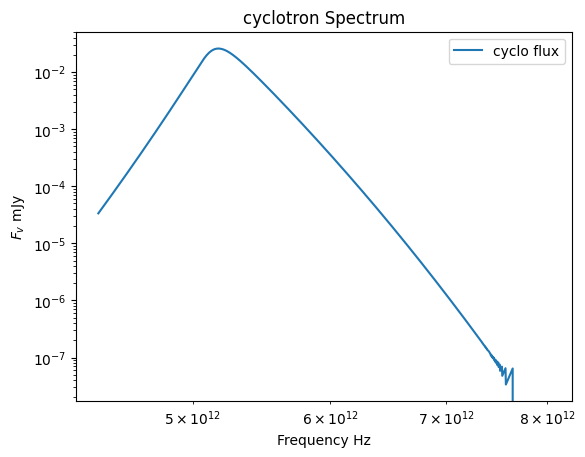

In [17]:
#make a cycltron emission  spectrum folliwng same process for synchrotron jet
lorentz_cyc_max = 2.0
lorentz_cyc_arr = np.linspace(lorentz_min, lorentz_cyc_max, num=1000)
cyc_momentum = momentum(lorentz_cyc_arr)

n_gamma  = number_distro(lorentz_cyc_arr)
#cyc_emission_integral = integrated_emmisivity(lorentz_min,lorentz_cyc_max,n_gamma,)
total_flux_cyc = []
total_int_cyc = []
p_cyc = 2.1
#make a new frequency array from larmor frequency

freq_cyc_min = cyclo_freq(lorentz_min, B_paper)
freq_cyc_max =  cyclo_freq(lorentz_cyc_max, B_paper)
freq_cyc_arr = np.linspace(freq_cyc_min, freq_cyc_max,1000)

for i in [0]: # only take first slice of jet as spectrum
    mag_temp =B_paper
    C_temp, C_hat_temp = C_constant(Ledd,temp_electron_energy, p=p_cyc)
    emission_temp = integrated_emmisivity(n_gamma, emissivity_cyc(freq_cyc_arr, mag_temp,cyc_momentum[i]))
    absorb_temp = absorption(freq_cyc_arr,C_hat_temp, mag_temp,p=p_cyc)
    source_temp = source(absorb_temp,emission_temp)
    tau_temp = optical_depth(absorb_temp, radiusSGRA)
    Iv_temp_cyc = Iv(source_temp,tau_temp)
    total_int.append(Iv_temp)
    Fv_temp = flux_spec(freq_cyc_arr, Iv_temp, radiusSGRA)
    total_flux_cyc.append(Fv_temp)
    #plt.plot(freq_arr,Fv_temp)

#make a new frequency array from charcteristic frequency i should probably define this as a funciton

total_spectrum_cyc = [sum(x) for x in zip(*total_flux_cyc)]
plt.title("cyclotron Spectrum")
plt.xscale('log')
plt.yscale("log")
plt.ylabel("$F_v$ mJy")
plt.xlabel("Frequency Hz")
plt.plot(freq_cyc_arr, total_spectrum_cyc, label= "cyclo flux")
plt.legend()
plt.show()


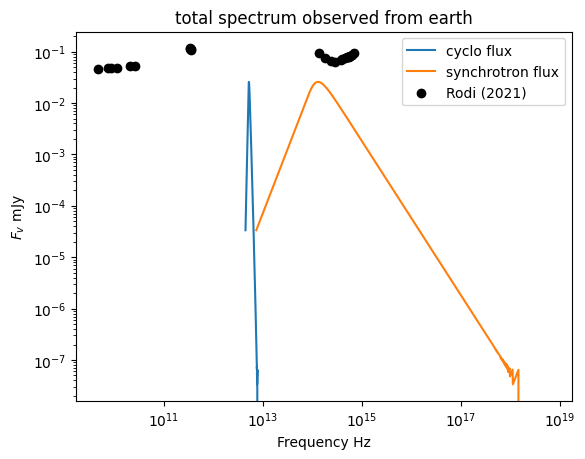

In [18]:
plt.plot(freq_cyc_arr, total_spectrum_cyc, color='tab:blue', label= "cyclo flux")
plt.plot(freq_arr, total_spectrum, color='tab:orange', label= "synchrotron flux")
plt.scatter(data_freq, data_flux, color='k',label='Rodi (2021)')
plt.xscale('log')
plt.yscale("log")
plt.ylabel("$F_v$ mJy")
plt.xlabel("Frequency Hz")
plt.title("total spectrum observed from earth")

plt.legend()
plt.savefig('test.png')
plt.show()

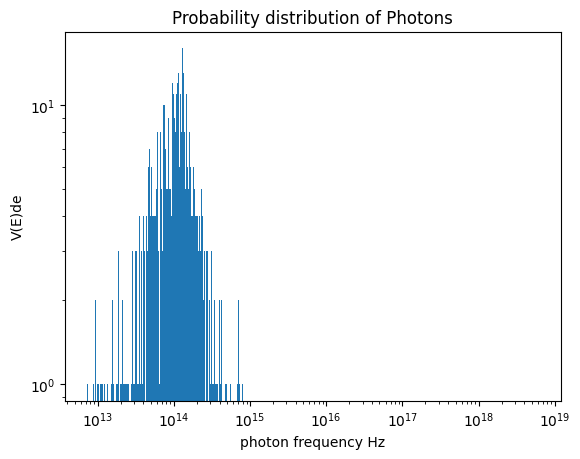

In [19]:
total_int_final = [sum(x) for x in zip(*total_int)]

electron_energy = np.linspace(me*lightspeed**2, lorentz*me*lightspeed**2, num=len(total_int_final))
photon_energy = planck*freq_arr
#make a distribution copied from the distribution demo
def freq_distro(intensity, photon_energy):
    '''Create a frequency distribution as function of energy
    v(e)de = intensity/hv
    input:
    Intensity-array of Intnesity spectrum cgs
    photon_ energy - array of energy cgs
    Variables:


    number_of_photons - float array of total number of photons in the jet
    pdf- probability density function for photon
    ve_distro - number of
    return- ve_distro, pdf'''

    number_of_photons= (intensity)/(4*np.pi*photon_energy)
    pdf = number_of_photons/np.sum(number_of_photons)
    cdf = np.cumsum(pdf)
    u = np.random.uniform(0, 1, size=len(photon_energy))
    ve_distro = np.interp(u, cdf, freq_arr)
    return ve_distro, pdf


#sample of photon distribtution input this as h*pdfVe to get energy of photon
ve_distro, pdfVE = freq_distro(total_int_final, photon_energy)
plt.hist(ve_distro, bins=freq_arr)
plt.xscale('log')
plt.yscale("log")
plt.ylabel("V(E)de")
plt.title("Probability distribution of Photons")
plt.xlabel("photon frequency Hz")
plt.show()

In [21]:
#sampled photon energy for SCC
E_samp_SCC = planck*ve_distro
len(E_samp_SCC)


1000

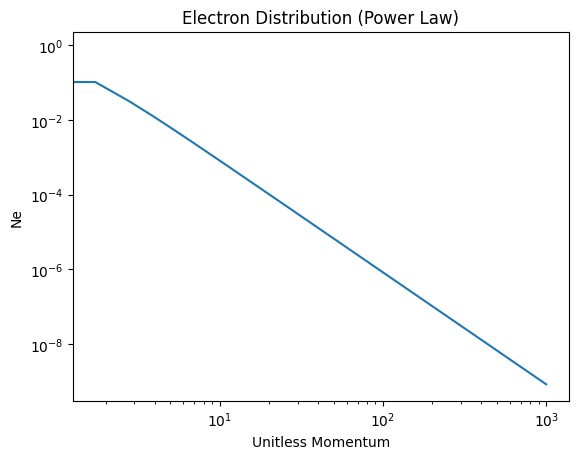

In [22]:
#create an electron distriubtion
def electron_distro(electron_energy, C,p):
    '''ne = C E^-p dE
    calculate the electron energy distribution
    input:
    electon_energy- array of energies
    C - from energy density see C_const funciton

    variables:
    number_of_electrons - similar to freq distro calculate the number of electrons
    from power law distro
    pdf- probability density function for number of electrons
    return
    ne, pdf'''
    number_of_electrons = C*(electron_energy**(-p+1)) #make a pdf of the electron distribution
    pdf = number_of_electrons/np.sum(number_of_electrons) # normalize the pdf
    cdf = np.cumsum(pdf) # make a cdf

    u = np.random.uniform(0, 1, size=len(electron_energy))
    ne = np.interp(u, cdf, electron_energy)
    return ne, pdf

#evaulate at the base of the jet
ne, pdfNE = electron_distro(electron_energy, C,p)
gamma_arr = electron_energy/(me*lightspeed**2)

momentum_arr = momentum(gamma_arr) # make a s unitless momentum array
plt.plot(momentum_arr, pdfNE) # plot as funcion of lorentz factor
plt.xscale('log')
plt.yscale("log")
#plt.hist(ne, bins=10, density=True, alpha=0.6, color='b')
plt.xlabel("Unitless Momentum")
plt.ylabel("Ne")
plt.title("Electron Distribution (Power Law)")
plt.savefig("powerlaw.png")
plt.show()

In [ ]:
#make a velocity distro of electrons
def vel_distro(lorentz):
    '''Calculate a velocity distribution for the electrons using lorentz factor
    input:
    lorentz - float arr of lorentz factors unitless
    variables:
    v - speed of electron in cm/s
    return:
    v'''
    v = lightspeed * np.sqrt(1 - 1/lorentz**2)
    return v
electron_vel = vel_distro(gamma_arr)

plt.plot(momentum_arr, electron_vel) # plot as funcion of lorentz factor
plt.xscale('log')
plt.yscale("log")
plt.xlabel("Unitless momentum")
plt.ylabel("velocity of electron cm/s")
plt.title("Velocity Distribution of electrons")
plt.show()

In [ ]:
#also plot Ne vs velocity
plt.plot(electron_vel, pdfNE ) # plot as funcion of lorentz factor
plt.xscale('log')
plt.yscale("log")
plt.ylabel("Ne")
plt.xlabel("velocity of electron cm/s")
plt.title("Velocity Distribution of electrons")
plt.show()

In [ ]:
c_light=lightspeed
m_electron=9.10938356e-28
sigma_t=6.65e-25
figure_counter=0

#copy the MC tutorial
def compton_y(pre,post):
    y = np.mean((post-pre)/pre)
    return(y)

def random_direction(number=None):
    if number is None:
        number=1
    phi=np.random.rand(number)*2.*np.pi
    cos_theta=2.*np.random.rand(number)-np.ones(number)
    sin_theta= np.sqrt(1-cos_theta**2)
    return((np.array([sin_theta*np.cos(phi),sin_theta*np.sin(phi),cos_theta])).transpose())

def f_of_hnu_mono(mc_parms,number=None):
    if number is None:
        number=1
    return(np.ones(number)*mc_parms['kt_seeds'])

def photon_origin(number=None):
    if number is None:
        number=1
    return(np.zeros([number,3]))

def draw_seed_photons(mc_parms,number=None):
    if number is None:
        number=1
    x_seed=photon_origin(number=number)
    n_seed=random_direction(number=number)
    hnu=mc_parms['hnu_dist'](mc_parms,number=number)
    p_seed=(np.array([hnu,hnu*n_seed[:,0],hnu*n_seed[:,1],hnu*np.abs(n_seed[:,2])])).transpose()/c_light
    return(p_seed,x_seed)

def tau_of_scatter():
    return(-np.log(np.random.rand()))

def distance_of_scatter(mc_parms):
    tau=tau_of_scatter()
    electron_density=mc_parms['tau']/mc_parms['H']/sigma_t
    distance=tau/sigma_t/electron_density
    return(distance)

def scatter_location(x_old,p_photon,mc_parms):
    distance = distance_of_scatter(mc_parms)
    photon_direction=p_photon[1:]/p_photon[0]
    x_new = x_old + distance*photon_direction
    return(x_new)

def f_of_v_mono(mc_parms):
    return(mc_parms['velocity'])

def draw_electron_velocity(mc_parms,p_photon):
    v=mc_parms['v_dist'](mc_parms)
    n=draw_electron_direction(v,p_photon)
    return(v*n)

def draw_electron_direction(v,p_photon):
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=mu_of_p_electron(v/c_light,np.random.rand())
    sint=np.sqrt(1 - cost**2)

    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)

    # express new vector in old base
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    return(n_new/np.sqrt(np.sum(n_new**2)))

def mu_of_p_electron(beta,p):
    mu=1/beta-np.sqrt(1/beta**2 + 1 - 4*p/beta + 2/beta)
    return(mu)

def lorentz_transform(p,v):
    beta=np.sqrt(np.sum(v**2))/c_light
    beta_vec=v/c_light
    gamma=1./np.sqrt(1. - beta**2)
    matrix=np.zeros((4,4))
    matrix[0,0]=gamma
    matrix[1:,0]=-gamma*beta_vec
    matrix[0,1:]=-gamma*beta_vec
    matrix[1:,1:]=(gamma-1)*np.outer(beta_vec,beta_vec)/beta**2
    for i in range(1,4):
        matrix[i,i]+=1
    return(np.dot(matrix,p))

def cos_theta_thomson(p):
    a=-4 + 8*p
    b=a**2 + 4
    return((np.power(2,1/3)*np.power(np.sqrt(b)-a,2/3)-2)/
           (np.power(2,2/3)*np.power(np.sqrt(b)-a,1/3)))

def thomson_scatter(p_photon):
    n_1=p_photon[1:]/p_photon[0]
    if (np.sum(np.abs(n_1[1:2])) != 0):
        n_2=np.cross(n_1,np.array([1,0,0]))
    else:
        n_2=np.cross(n_1,np.array([0,1,0]))
    n_2/=np.sqrt(np.sum(n_2**2))
    n_3=np.cross(n_1,n_2)
    phi=2.*np.pi*np.random.rand()
    cosp=np.cos(phi)
    sinp=np.sin(phi)
    cost=cos_theta_thomson(np.random.rand())
    sint=np.sqrt(1 - cost**2)
    n_new=(n_2*cosp+n_3*sinp)*sint + n_1*cost
    n_new/=np.sqrt(np.sum(n_new**2))
    return(np.array(p_photon[0]*np.array([1,n_new[0],n_new[1],n_new[2]])))

def inverse_compton_scatter(p_photon,mc_parms):
    velocity=draw_electron_velocity(mc_parms,p_photon)
    p_photon_prime=lorentz_transform(p_photon,velocity)
    p_out_prime=thomson_scatter(p_photon_prime)
    return(lorentz_transform(p_out_prime,-velocity))

def monte_carlo(mc_parms):
    hnu_seed=np.zeros(mc_parms['n_photons'])
    hnu_scattered=hnu_seed.copy()
    p_photons,x_photons=draw_seed_photons(mc_parms,number=mc_parms['n_photons'])
    for p_photon,x_photon,i in zip(p_photons,x_photons,range(mc_parms['n_photons'])):
        hnu_seed[i]=p_photon[0]*c_light
        scattered=True
        while (scattered):
            x_photon = scatter_location(x_photon,p_photon,mc_parms)
            if (x_photon[2]>=0 and x_photon[2]<=mc_parms['H']):
                p_photon=inverse_compton_scatter(p_photon,mc_parms)
            else:
                scattered=False
                if (x_photon[2]<=0):
                    p_photon*=0
        hnu_scattered[i]=p_photon[0]*c_light
    return(hnu_scattered[hnu_scattered > 0],hnu_seed[hnu_scattered > 0])

def plot_mc(mc_parms,bins=None,xlims=None,filename=None):
    global figure_counter
    if (xlims is None):
        xlims=[0.1,100]
    if (bins is None):
        bins=np.logspace(np.log10(xlims[0]),np.log10(xlims[1]),num=100)
    if (filename is None):
        filename='inverse_compton_MC_{0:d}.pdf'.format(figure_counter)
    hnu_scattered,hnu_seeds=np.array(monte_carlo(mc_parms))/mc_parms['kt_seeds']
    fig=plt.figure()
    plt.hist(hnu_scattered,bins=bins,log=True,
             label=r'$\tau=${:4.1f}'.format(mc_parms['tau']))
    plt.xscale('log')
    plt.xlim(xlims[0],xlims[1])
    plt.xlabel(r'$h\nu/h\nu_{0}$')
    plt.ylabel(r'$N(h\nu)$')
    plt.legend()
    #fig.savefig(filename)
    figure_counter+=1
    plt.show()
    print('Fraction of escaping photons: {0:5.3e}\n'.format(hnu_scattered.size/mc_parms['n_photons']))
    print('Compton y parameter: {0:5.3e}\n'.format(compton_y(hnu_seeds,hnu_scattered)))
    return(hnu_scattered,hnu_seeds)

# mc_parms={'n_photons':10000,'kt_seeds':1.6e-9,'H':1e7,'velocity':3e9,'tau':0.1,'v_dist':f_of_v_mono,'hnu_dist':f_of_hnu_mono}

# hnu_scattered,hnu_seeds=plot_mc(mc_parms,bins=100)

def f_of_v_maxwell(mc_parms):
    v=3e10
    while v >= c_light:
        v=np.sqrt(mc_parms['kt_electron']/(m_electron))*np.sqrt(np.sum((np.random.normal(0,1,3))**2))
    return(v)

# mc_parms={'n_photons':10000,'kt_seeds':1.6e-9,'H':1e7,'velocity':3e9,'tau':0.1,'kt_electron':3.2e-8,'v_dist':f_of_v_maxwell,'hnu_dist':f_of_hnu_mono}
# mc_parms['velocity']=np.sqrt(mc_parms['kt_electron']/(m_electron))
# hnu_scattered,hnu_seeds=plot_mc(mc_parms)

def f_planck(x):
    norm=2.4041138063192817
    return x**2/(np.exp(x)-1)/norm

def p_planck(hnu=None):
    if (hnu is None):
        number=1000
        hnu=np.append(np.linspace(0,1-1./number,number),np.logspace(0,4,number))

    p=np.zeros(2*number)
    for i in range(1,2*number):
        p[i]=((quad(f_planck,0,hnu[i]))[0])
    return (p,hnu)

def hnu_of_p_planck(number=None,pdf=None,hnu=None):
    if number is None:
        number=1
    if (pdf is None):
        pdf,hnu=p_planck()

    e_phot=np.interp(np.random.rand(number),pdf,hnu)
    return(e_phot,pdf,hnu)

def f_of_hnu_planck(mc_parms,number=None,pdf=None,energies=None):
    if number is None:
        number=1
    if (pdf is None):
        e,pdf,energies=hnu_of_p_planck(number=number)
    else:
        e,pdf,energies=hnu_of_p_planck(number=number,pdf=pdf,hnu=energies)
    e*=mc_parms['kt_seeds']
    return(e)
def f_of_hnu_corona(mc_parms,number):
  return E_samp_SCC



In [ ]:


#modify the monte carlo sim so that the inputs come from my spectrum
def f_of_v_maxwell(mc_parms):
    v=3e10
    while v >= c_light:
        v=np.sqrt(mc_parms['kt_electron']/(m_electron))*np.sqrt(np.sum((np.random.normal(0,1,3))**2))
    return(v)

#modify the hnu_planck fuction using the distribution calculated from my Jet
#pdf = pdfVE
def f_of_photons(mc_parms,number=None,pdf=None,energies=None):
    if number is None:
        number=1
    if (pdf is None):
        pdf = pdfVE
        e,temp,energies=hnu_of_p_planck(number=number)
    else:
        e,pdf,energies=hnu_of_p_planck(number=number,pdf=pdfVE,hnu=energies)
    e*=mc_parms['kt_seeds']
    return(e)
my_mc_parms={'n_photons':10000,
          'kt_seeds':1.6e-9,
          'H':1e7,
          'tau':0.1,
          'kt_electron':3.2e-8,
          'v_dist':f_of_v_maxwell,
          'hnu_dist':f_of_photons}

hnu_scattered,hnu_seeds=plot_mc(my_mc_parms)

In [ ]:
mc_parms={'n_photons':10,            # start somewhat small and go up
          'kt_seeds':1.6e-9,            # 1 keV input photons
          'H':1e7,                      # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
          'velocity':3e9,               # 10% speed of light--pretty hot
          'tau':1.0,                    # tau ~ 0.1: Small-ish optical depth
          'kt_electron':3.2e-8,         # electron temperature: 20 keV
          'v_dist':0,      # name of maxwell jutner function
          'hnu_dist':f_of_hnu_planck,   # name of photon distribution function
          'gamma_min':1.1,
          'gamma_max':1000.0
         }

def jutner(mc_parms):
    '''Make a maxwell juttner distribution using mc_parms in put
  input:
  mc_parms: gamma_min aand gamma_max, unitless
  variables:
  f_gamma: the  distribution in terms of lorentz factor
  return f_gamma
    '''
    theta = mc_parms['kt_electron']/(m_electron*c_light**2)
    gamma_arr = np.linspace(mc_parms['gamma_min'], mc_parms['gamma_max'])
    bessel = kv(2, 1/theta) # evaluate the bessel at one value of theta
    beta = np.sqrt( 1 -1/(gamma_arr)**2)

    f_gamma = ((gamma_arr**2)*beta/(theta * bessel) ) * np.exp(-gamma_arr/theta) # make the distro in terms of gamma

    return f_gamma
result_of_jutner = jutner(mc_parms)
def sample_jutner(mc_parms):
    ''' sample a velocity from the MJ distribution
    sample a random lorentz factor
    convert this to a velocity to input into the monte carlo
    input:
     mc_parms: gamma_min aand gamma_max, unitless
     variables
     pdf: probability distribution function for the MJ
     gamma_inv: the sampled lorenrtz factor
     return
     velocity of photon at the given gamma

    '''
    n = 1
    pdf = result_of_jutner
    pdf = pdf/np.sum(pdf)
    cdf = np.cumsum(pdf)
    cdf = np.cumsum(pdf)
    gamma_arr = np.linspace(mc_parms['gamma_min'], mc_parms['gamma_max'])
    # Generate n random numbers from a uniform distribution between 0 and 1
    u = np.random.uniform(0, 1, size=n)
    # Interpolate the inverse cdf function using numpy.interp
    gamma_inv = np.interp(u, cdf, gamma_arr)
    #convert to velocity
    v = c_light*(np.sqrt(1 - 1/(gamma_inv**2)))
    return v

def wrapper_for_junter(mc_parms):
    '''MC tutorial needs a wrapper function '''
    x = sample_jutner(mc_parms)
    return x

In [ ]:
mc_parms={'n_photons':10000,            # start somewhat small and go up
          'kt_seeds':1.6e-9,            # 1 keV input photons
          'H':1e7,                      # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
          'velocity':3e9,               # 10% speed of light--pretty hot
          'tau':1.0,                    # tau ~ 0.1: Small-ish optical depth
          'kt_electron':3.2e-8,         # electron temperature: 20 keV
          'v_dist':wrapper_for_junter,      # name of maxwell jutner function
          'hnu_dist':f_of_hnu_planck,   # name of photon distribution function
          'gamma_min':2,
          'gamma_max':1000.0
         }

In [ ]:

def f_of_v_maxwell_jutner(mc_parms):
    """Returns a single randomly drawn velocity from distribution function
    Make a maxwell jutner distribution in terms of lorentz factor
    covert this to  a velocity
    Do this for fixed electron temperature KT

    Args:
        mc_parms (dictionary): Monte-Carlo parameters

    Returns:
        real: electron velocity drawn from distribution
    """
    theta = mc_parms['kt_electron']/(m_electron*c_light**2)
    gamma_arr = np.linspace(mc_parms['gamma_min'], mc_parms['gamma_max'])
    bessel = kv(2, 1/theta) # evaluate the bessel at one value of theta
    beta = np.sqrt( 1 -1/(gamma_arr)**2)

    f_gamma = ((gamma_arr**2)*beta/(theta * bessel) ) * np.exp(-gamma_arr/theta) # make the distro in terms of gamma


    v=3e10 # needed for clipping... copied from MC tutorial
    while v >= c_light:
        v  = c_light*np.sqrt(1 - 1/(f_gamma)**2)
    return(v)

jutner_test = jutner(mc_parms)
jutner_vel = sample_jutner(mc_parms)

In [ ]:
mc_parms={'n_photons':10000,            # start somewhat small and go up
          'kt_seeds':1.6e-9,            # 1 keV input photons
          'H':8*rg,                      # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
          'velocity':3e9,               # 10% speed of light--pretty hot
          'tau':1.0,                    # tau ~ 0.1: Small-ish optical depth
          'kt_electron':3.2e-8,         # electron temperature: 20 keV
          'v_dist':wrapper_for_junter,      # name of maxwell jutner function
          'hnu_dist':f_of_hnu_planck,   # name of photon distribution function
          'gamma_min':2,
          'gamma_max':1000.0
         }
hnu_scattered_pmc,hnu_seeds_pmc=plot_mc(mc_parms, xlims=[1e-3, 1e20]);
hnu_scattered_mc,hnu_seeds_mc=monte_carlo(mc_parms);

In [ ]:
plt.hist(hnu_scattered_pmc);

In [ ]:
plt.hist(hnu_scattered_mc);

In [ ]:
plt.hist(np.log(hnu_scattered_pmc));

In [ ]:
plt.hist(np.log(hnu_scattered_mc));

In [ ]:
mc_parms={'n_photons':len(E_samp_SCC),            # start somewhat small and go up
          'kt_seeds':1.6e-9,            # 1 keV input photons
          'H':1e7,                      # say H ~ R, and R ~ 100 R_g ~ 3e7 cm
          'velocity':3e9,               # 10% speed of light--pretty hot
          'tau':1.0,                    # tau ~ 0.1: Small-ish optical depth
          'kt_electron':3.2e-8,         # electron temperature: 20 keV
          'v_dist':wrapper_for_junter,      # name of maxwell jutner function
          'hnu_dist':f_of_hnu_corona,   # name of photon distribution function
          'gamma_min':2,
          'gamma_max':1000.0
         }
hnu_scattered,hnu_seeds=plot_mc(mc_parms, xlims=[1e-3, 1e20]);